In [14]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
import sklearn
from datetime import date, datetime, timedelta
from sklearn.linear_model import LinearRegression
from itertools import product
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
def plot_elasticity(estimator, elast_var, X, y, n_sim = 10000, pts = [50]):
    
    data_elast = pd.DataFrame(n_sim * [X[elast_var].median()], columns = [elast_var])
    feat_vars = X.columns
      
    for sim_var in feat_vars:
        if (sim_var != elast_var):
            data_elast[sim_var] = X[sim_var].sample(n=n_sim, replace=True, axis=0).values          
    data_elast['y_pred'] = np.exp(estimator.predict(data_elast[feat_vars]))
    data_elast = data_elast.sort_values(by = 'y_pred', axis = 0).reset_index()

    pt_dfs = {}
    for pt in pts:
        elast_df_pt = pd.DataFrame([data_elast[feat_vars].iloc[int(pt/100 * n_sim)]] * 
                                   len(X.index), index = X.index)
        elast_df_pt[elast_var] = X[elast_var].values
        y_pred_pt = np.exp(estimator.predict(elast_df_pt[feat_vars]))
        
        elast_df_0 = pd.DataFrame([data_elast[feat_vars].iloc[int(pt/100 * n_sim)]] * 
                                  len(X.index), index = X.index)
        elast_df_0[elast_var] = 0
        y_pred_0 = np.exp(estimator.predict(elast_df_0[feat_vars]))
        
        elast_df_pt['y_pred'] = y_pred_pt - y_pred_0
        elast_df_pt = elast_df_pt.sort_values(by = elast_var, axis = 0)
        pt_dfs[pt] = elast_df_pt
       
    elast_df_0 = X.copy()
    elast_df_0[elast_var] = 0
    y_0 = np.exp(y) - np.exp(estimator.predict(elast_df_0[feat_vars]))
    
    fig, ax = plt.subplots(figsize = (16, 8))
    ax2 = ax.twinx()
    ax.hist(X[elast_var], color = 'pink')
    
    ax2.scatter(X[elast_var], y_0, color = 'gray', s = 20)
        
    for (pt, pt_df) in pt_dfs.items():
        ax2.plot(pt_df[elast_var], pt_df['y_pred'], color = 'blue', linestyle='--',
                                   dashes=(int(5.5-abs(pt/10-5)), 1+int(abs(5-pt/10))))
        
    plt.title('Очищенная эластичность конвертации по ' + elast_var)
    plt.show()

# Предобработка данных

## Загрузка

In [3]:
Currency = 'RUB'

In [4]:
# List of companies
xl = pd.ExcelFile('Comp_list.xlsx')
Comps = xl.parse('Comps')

Comps['Group'] = Comps['Group'].fillna(Comps['Client_name'])
Comps['GroupID'] = Comps['Group'].rank(method='dense').astype(int)

Comps

,CRM-ID,Client_name,Group,Type,GroupID
0,1-106ZRMS,SPARINVEST FONDSMGLERSELSKAB A/S,SPARINVEST FONDSMGLERSELSKAB A/S,Stand_alone,1126
1,1-10BNSES,Адмирал,ФСК Лидер,Холдниг,2471
2,1-10C4NZT,Русская Платина,Группа Бажаева,Конгломерат,1665
3,1-10C4O7V,Nord Gold SE,Севергрупп,Конгломерат,2320
4,1-10CH93G,ПРОМЫШЛЕННОЕ ПРЕДПРИЯТИЕ ТИТАНГРУПП,ПИК,Холдниг,2152
5,1-10E85R,СОВМЕСТНОЕ ПРЕДПРИЯТИЕ САХАЛИН ТЕЛЕКОМ ЛИМИТЕД,Альфа-Групп,Конгломерат,1497
6,1-10EINH,Архангельский ликеро-водочный завод,Белуга Групп,Холдниг,1573
7,1-10OX09W,VTB CAPITAL RUSSIA & CIS EQUITY FUND LTD (CAYM...,ВТБ,Холдниг,1591
8,1-10UTCOA,ГУ -ПЕНСИОННЫЙ РОССИЙСКОЙ ФЕДЕРАЦИИ,Финансовый блок,Холдниг,2478
9,1-10V6VR2,VTB CAPITAL RUSSIA & CIS FIXED INCOME FUND LTD...,ВТБ,Холдниг,1591


In [5]:
# Transaction data
Deals_all = pd.read_csv("Deals_all.csv", sep=";", low_memory=False, encoding="cp1251")

Deals_all['Term'] = Deals_all['Term'].astype(int)
Deals_all['AmountCCY'] = Deals_all['AmountCCY'].astype(float)
Deals_all['InterestRate'] = Deals_all['InterestRate'].astype(float)

Deals_all['DealDate'] = Deals_all['DealDate'].apply(lambda x:
                        datetime(int(x[:4]), int(x[5:7]), int(x[8:10])).date())
Deals_all['ValueDate'] = Deals_all['ValueDate'].apply(lambda x:
                         datetime(int(x[:4]), int(x[5:7]), int(x[8:10])).date())
Deals_all['MaturityDate'] = Deals_all['MaturityDate'].apply(lambda x:
                            datetime(int(x[:4]), int(x[5:7]), int(x[8:10])).date())

Deals_all = Deals_all[Deals_all['AmountCCY'] > 0]
Deals_all = Deals_all[Deals_all['Term'] > 0]
Deals_all['Amount_log'] = np.log(Deals_all['AmountCCY'])

Deals_all

,CRM_ID,Product,CCY,Term,AmountCCY,IsTopup,IsPartWithdraw,IsFullWithdraw,DealDate,ValueDate,MaturityDate,InterestRate,INN,Amount_log
0,1-5HES5S,NSO,RUB,3,7.000000e+07,0,0,1,2017-10-06,2017-10-06,2017-10-09,0.0515,2.303024e+09,18.064006
1,1-1CC96BK,NSO,RUB,1,1.200000e+07,0,0,1,2017-10-09,2017-10-09,2017-10-10,0.0509,7.722792e+09,16.300417
2,1-49B5QF0,NSO,RUB,1,5.600000e+07,0,0,1,2018-01-30,2018-01-30,2018-01-31,0.0450,7.704871e+09,17.840862
3,1-1PJW4YB,NSO,RUB,1,1.000000e+07,0,0,1,2016-08-17,2016-08-17,2016-08-18,0.0703,7.802755e+09,16.118096
4,1-T3YGM,NSO,RUB,1,2.439000e+07,0,0,1,2017-08-07,2017-08-07,2017-08-08,0.0538,7.735081e+09,17.009684
5,1-G659SXA,NSO,RUB,1,8.750000e+07,0,0,1,2018-01-11,2018-01-11,2018-01-12,0.0530,7.714928e+09,18.287149
6,1-1LMMF,NSO,RUB,3,1.480000e+08,0,0,1,2018-09-21,2018-09-21,2018-09-24,0.0653,7.014028e+09,18.812723
7,1-3HXDXDI,NSO,RUB,2,4.428500e+07,0,0,1,2016-08-29,2016-08-29,2016-08-31,0.0680,7.453280e+09,17.606157
8,1-1MSTU,NSO,RUB,3,6.000000e+07,0,0,1,2018-02-02,2018-02-02,2018-02-05,0.0454,7.724314e+09,17.909855
9,1-6ALIVU,NSO,RUB,1,6.490000e+07,0,0,1,2018-03-12,2018-03-12,2018-03-13,0.0427,6.154094e+09,17.988358


In [6]:
# Select segment
Deals = Deals_all[(Deals_all['CRM_ID'].isin(Comps['CRM-ID'])) &
                  (Deals_all['CCY'] == Currency) &
                  (Deals_all['DealDate'] >= date(2017, 1, 1))]

# Merge with groups
Deals = Deals.merge(Comps[['CRM-ID', 'GroupID']], left_on='CRM_ID', right_on='CRM-ID')

Deals['AmountCCY_log'] = np.log(Deals['AmountCCY'])

Deals

,CRM_ID,Product,CCY,Term,AmountCCY,IsTopup,IsPartWithdraw,IsFullWithdraw,DealDate,ValueDate,MaturityDate,InterestRate,INN,Amount_log,CRM-ID,GroupID,AmountCCY_log
0,1-5HES5S,NSO,RUB,3,7.000000e+07,0,0,1,2017-10-06,2017-10-06,2017-10-09,0.0515,2.303024e+09,18.064006,1-5HES5S,1650,18.064006
1,1-5HES5S,NSO,RUB,1,2.450000e+08,0,0,1,2017-10-11,2017-10-11,2017-10-12,0.0624,2.303024e+09,19.316769,1-5HES5S,1650,19.316769
2,1-5HES5S,NSO,RUB,1,1.000000e+07,0,0,1,2018-08-14,2018-08-14,2018-08-15,0.0419,2.303024e+09,16.118096,1-5HES5S,1650,16.118096
3,1-5HES5S,NSO,RUB,1,2.000000e+07,0,0,1,2017-07-19,2017-07-19,2017-07-20,0.0573,2.303024e+09,16.811243,1-5HES5S,1650,16.811243
4,1-5HES5S,NSO,RUB,3,6.050000e+08,0,0,1,2018-09-07,2018-09-07,2018-09-10,0.0513,2.303024e+09,20.220739,1-5HES5S,1650,20.220739
5,1-5HES5S,NSO,RUB,1,1.000000e+07,0,0,1,2017-10-11,2017-10-11,2017-10-12,0.0515,2.303024e+09,16.118096,1-5HES5S,1650,16.118096
6,1-5HES5S,NSO,RUB,1,1.200000e+08,0,0,1,2018-07-26,2018-07-26,2018-07-27,0.0500,2.303024e+09,18.603002,1-5HES5S,1650,18.603002
7,1-5HES5S,NSO,RUB,2,6.400000e+07,0,0,1,2017-06-20,2017-06-20,2017-06-22,0.0592,2.303024e+09,17.974394,1-5HES5S,1650,17.974394
8,1-5HES5S,NSO,RUB,4,7.500000e+07,0,0,1,2017-12-27,2017-12-27,2017-12-31,0.0489,2.303024e+09,18.132999,1-5HES5S,1650,18.132999
9,1-5HES5S,NSO,RUB,3,1.000000e+07,0,0,1,2018-01-12,2018-01-12,2018-01-15,0.0433,2.303024e+09,16.118096,1-5HES5S,1650,16.118096


In [7]:
xl = pd.ExcelFile('MosPrime.xlsx')
MosPrime = xl.parse('MosPrime').dropna()

MosPrime[1] = MosPrime['ON']
MosPrime[2] = MosPrime['ON'] + (2.0 - 1.0) * (MosPrime['1W'] - MosPrime['ON']) / 6
MosPrime[3] = MosPrime['ON'] + (3.0 - 1.0) * (MosPrime['1W'] - MosPrime['ON']) / 6
MosPrime[4] = MosPrime['ON'] + (4.0 - 1.0) * (MosPrime['1W'] - MosPrime['ON']) / 6
MosPrime[5] = MosPrime['ON'] + (5.0 - 1.0) * (MosPrime['1W'] - MosPrime['ON']) / 6
MosPrime[6] = MosPrime['ON'] + (6.0 - 1.0) * (MosPrime['1W'] - MosPrime['ON']) / 6

MosPrime['Date'] = MosPrime['Date'].apply(lambda x: x.date())

MosPrime

,Date,ON,1W,2W,1M,2M,3M,6M,1,2,3,4,5,6
0,2018-09-10,7.29,7.39,7.46,7.54,7.68,7.74,7.79,7.29,7.306667,7.323333,7.340,7.356667,7.373333
1,2018-09-07,7.28,7.40,7.47,7.53,7.67,7.73,7.78,7.28,7.300000,7.320000,7.340,7.360000,7.380000
2,2018-09-06,7.28,7.38,7.40,7.51,7.63,7.70,7.73,7.28,7.296667,7.313333,7.330,7.346667,7.363333
3,2018-09-05,7.30,7.38,7.36,7.50,7.62,7.68,7.70,7.30,7.313333,7.326667,7.340,7.353333,7.366667
4,2018-09-04,7.34,7.38,7.36,7.52,7.62,7.68,7.71,7.34,7.346667,7.353333,7.360,7.366667,7.373333
5,2018-09-03,7.36,7.38,7.37,7.53,7.61,7.68,7.70,7.36,7.363333,7.366667,7.370,7.373333,7.376667
6,2018-08-31,7.37,7.38,7.38,7.53,7.61,7.66,7.68,7.37,7.371667,7.373333,7.375,7.376667,7.378333
7,2018-08-30,7.33,7.39,7.39,7.53,7.60,7.66,7.68,7.33,7.340000,7.350000,7.360,7.370000,7.380000
8,2018-08-29,7.38,7.41,7.40,7.51,7.60,7.65,7.67,7.38,7.385000,7.390000,7.395,7.400000,7.405000
9,2018-08-28,7.33,7.36,7.39,7.47,7.58,7.62,7.63,7.33,7.335000,7.340000,7.345,7.350000,7.355000


## Descriptive analysis

In [8]:
All_group = Deals.groupby(['CRM_ID', 'CCY']).agg({'CRM_ID' : 'count'})
All_group.columns = ['Count']
All_group = All_group.reset_index().pivot(index = 'CRM_ID', columns = 'CCY', values = 'Count')

All_comps = pd.DataFrame(index = Comps['CRM-ID']).join(All_group).fillna(0)
All_comps = All_comps.astype(int)
All_comps.columns = ['Count']
All_comps

,Count
CRM-ID,
1-106ZRMS,0
1-10BNSES,0
1-10C4NZT,0
1-10C4O7V,0
1-10CH93G,0
1-10E85R,0
1-10EINH,0
1-10OX09W,0
1-10UTCOA,0


## Чистка данных

In [9]:
Deals_MosPrime = Deals.merge(MosPrime[['Date',1,2,3,4,5,6]], how = "left", left_on = 'DealDate', right_on = 'Date')
Deals_MosPrime['MosPrimeBase'] = Deals_MosPrime.apply(lambda row: row[row['Term']], axis = 1) / 100
Deals_MosPrime['Spread'] = Deals_MosPrime['MosPrimeBase'] - Deals_MosPrime['InterestRate']

Deals_MosPrime['Const'] = 1

Deals_MosPrime = Deals_MosPrime.dropna()
Deals_MosPrime

,CRM_ID,Product,CCY,Term,AmountCCY,IsTopup,IsPartWithdraw,IsFullWithdraw,DealDate,ValueDate,...,Date,1,2,3,4,5,6,MosPrimeBase,Spread,Const
0,1-5HES5S,NSO,RUB,3,7.000000e+07,0,0,1,2017-10-06,2017-10-06,...,2017-10-06,8.44,8.448333,8.456667,8.465,8.473333,8.481667,0.084567,0.033067,1
1,1-5HES5S,NSO,RUB,1,2.450000e+08,0,0,1,2017-10-11,2017-10-11,...,2017-10-11,8.30,8.338333,8.376667,8.415,8.453333,8.491667,0.083000,0.020600,1
2,1-5HES5S,NSO,RUB,1,1.000000e+07,0,0,1,2018-08-14,2018-08-14,...,2018-08-14,7.33,7.333333,7.336667,7.340,7.343333,7.346667,0.073300,0.031400,1
3,1-5HES5S,NSO,RUB,1,2.000000e+07,0,0,1,2017-07-19,2017-07-19,...,2017-07-19,9.20,9.205000,9.210000,9.215,9.220000,9.225000,0.092000,0.034700,1
4,1-5HES5S,NSO,RUB,3,6.050000e+08,0,0,1,2018-09-07,2018-09-07,...,2018-09-07,7.28,7.300000,7.320000,7.340,7.360000,7.380000,0.073200,0.021900,1
5,1-5HES5S,NSO,RUB,1,1.000000e+07,0,0,1,2017-10-11,2017-10-11,...,2017-10-11,8.30,8.338333,8.376667,8.415,8.453333,8.491667,0.083000,0.031500,1
6,1-5HES5S,NSO,RUB,1,1.200000e+08,0,0,1,2018-07-26,2018-07-26,...,2018-07-26,7.33,7.330000,7.330000,7.330,7.330000,7.330000,0.073300,0.023300,1
7,1-5HES5S,NSO,RUB,2,6.400000e+07,0,0,1,2017-06-20,2017-06-20,...,2017-06-20,9.20,9.203333,9.206667,9.210,9.213333,9.216667,0.092033,0.032833,1
8,1-5HES5S,NSO,RUB,4,7.500000e+07,0,0,1,2017-12-27,2017-12-27,...,2017-12-27,7.98,7.980000,7.980000,7.980,7.980000,7.980000,0.079800,0.030900,1
9,1-5HES5S,NSO,RUB,3,1.000000e+07,0,0,1,2018-01-12,2018-01-12,...,2018-01-12,7.42,7.465000,7.510000,7.555,7.600000,7.645000,0.075100,0.031800,1


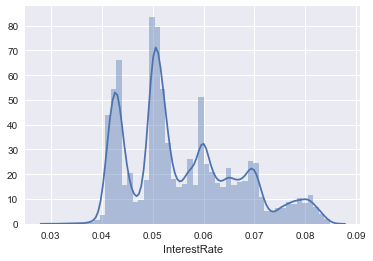

In [10]:
Deals_MosPrime = Deals_MosPrime[Deals_MosPrime['InterestRate'] > 0.03]
Deals_MosPrime = Deals_MosPrime[Deals_MosPrime['InterestRate'] < Deals_MosPrime['MosPrimeBase']]

sns.distplot(Deals_MosPrime['InterestRate']);

In [12]:
my_df

,CRM_ID,Product,CCY,Term,AmountCCY,IsTopup,IsPartWithdraw,IsFullWithdraw,DealDate,ValueDate,...,2,3,4,5,6,MosPrimeBase,Spread,Const,Spread_%,m-y
88063,1-1E06GHG,NSO,RUB,1,1.350000e+07,0,0,1,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.022500,1,0.305707,"(9, 2018)"
169621,1-1PC5TFW,Deposit,RUB,1,2.010000e+08,0,0,0,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.022500,1,0.305707,"(9, 2018)"
112906,1-VO4YN,NSO,RUB,1,2.100000e+07,0,0,1,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.031400,1,0.426630,"(9, 2018)"
88009,1-3I0ESL0,NSO,RUB,1,2.000000e+07,0,0,1,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.031400,1,0.426630,"(9, 2018)"
161574,1-A28B3S,Deposit,RUB,1,3.290000e+07,0,0,0,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.029800,1,0.404891,"(9, 2018)"
78064,1-I7OJ,NSO,RUB,1,3.397500e+09,0,0,1,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.020600,1,0.279891,"(9, 2018)"
119799,1-E648T,NSO,RUB,1,1.200000e+09,0,0,1,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.022900,1,0.311141,"(9, 2018)"
11316,1-QSNL1,NSO,RUB,1,1.352311e+07,0,0,1,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.031600,1,0.429348,"(9, 2018)"
171741,1-3GINU0U,Deposit,RUB,1,1.480000e+07,0,0,0,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.031400,1,0.426630,"(9, 2018)"
172493,1-9AB254,Deposit,RUB,1,1.570000e+08,0,0,0,2018-09-03,2018-09-03,...,7.363333,7.366667,7.37,7.373333,7.376667,0.073600,0.022500,1,0.305707,"(9, 2018)"


In [19]:
Deals_MosPrime['Spread_%'] = Deals_MosPrime['Spread'] / Deals_MosPrime['MosPrimeBase']
Deals_MosPrime = Deals_MosPrime.sort_values(by = 'DealDate')
Deals_MosPrime['m-y'] = Deals_MosPrime['DealDate'].apply(lambda x: (x.month, x.year))
my_list = list(Deals_MosPrime.groupby('m-y')['m-y'].count().index)

buckets = {'1-3':[1,2,3],
           '4':[4],
           '5':[5],
           '6':[6]}

for f in buckets.keys():
    try:
        os.mkdir("img_RUB//term " + str(f))
    except FileExistsError:
        pass
    
    i = 0
    for my in pd.DataFrame(my_list).sort_values(by=[1,0]).iterrows():
        my_str = str(my[1][0]) + "-" + str(my[1][1])
        my_df = Deals_MosPrime[((Deals_MosPrime['Term'].isin(buckets[f])) &
                                (Deals_MosPrime['DealDate'].apply(lambda x: str(x.month) + "-" + str(x.year)) == my_str))]

        fig, ax = plt.subplots()
        ax.hist(my_df['Spread_%'])
        ax.set_title(my_str)

        i += 1
        plt.savefig('img_RUB//term ' + str(f) + '//Spread%_hist_' + str(i))
        plt.close(fig)

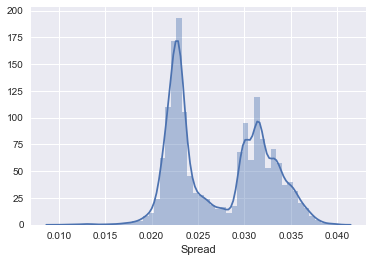

In [11]:
Deals_MosPrime = Deals_MosPrime[(Deals_MosPrime['Spread'] <= 0.04) &
                                (Deals_MosPrime['Spread'] > 0.01)]
sns.distplot(Deals_MosPrime['Spread']);

## Панельная регрессия

In [12]:
Obs_Count = Deals_MosPrime.groupby('GroupID').agg({'GroupID' : 'count'})
Obs_Count.columns = ['Count']

In [13]:
common_dummies = pd.get_dummies(Deals_MosPrime['GroupID'])
suff_cols = [c for c in common_dummies.columns if c not in Obs_Count[Obs_Count['Count'] < 25].index]

INN_d = common_dummies[suff_cols].add_prefix('C_')
INN_cols = INN_d.columns.tolist()

Tenor_d = common_dummies[suff_cols].mul(Deals_MosPrime['Term'], axis=0).add_prefix('T_')
Tenor_cols = Tenor_d.columns.tolist()

Amount_log_d = common_dummies[suff_cols].mul(Deals_MosPrime['Amount_log'], axis=0).add_prefix('AMT_')
Amount_log_cols = Amount_log_d.columns.tolist()

MosPrime_d = common_dummies[suff_cols].mul(Deals_MosPrime['MosPrimeBase'], axis=0).add_prefix('MS_')
MosPrime_cols = MosPrime_d.columns.tolist()

"""
suff_cols = [c for c in common_dummies.columns if c not in Obs_Count[Obs_Count['Count'] < 50].index]
DepositIsTopup_d = common_dummies[suff_cols].mul(Deals_MosPrime['DepositIsTopup'], axis=0).add_prefix('DTP_')
DepositIsTopup_cols = DepositIsTopup_d.columns.tolist()

suff_cols = [c for c in common_dummies.columns if c not in Obs_Count[Obs_Count['Count'] < 50].index]
IsPartWithdraw_d = common_dummies[suff_cols].mul(Deals_MosPrime['IsPartWithdraw'], axis=0).add_prefix('IPW_')
IsPartWithdraw_cols = IsPartWithdraw_d.columns.tolist()

suff_cols = [c for c in common_dummies.columns if c not in Obs_Count[Obs_Count['Count'] < 50].index]
IsFullWithdraw_d = common_dummies[suff_cols].mul(Deals_MosPrime['IsFullWithdraw'], axis=0).add_prefix('IFW_')
IsFullWithdraw_cols = IsFullWithdraw_d.columns.tolist()
"""

Prod_d = pd.get_dummies(Deals_MosPrime['Product'])
Prod_cols = Prod_d.columns.tolist()[1:]

"""
Month_d = pd.get_dummies(Deals_MosPrime['DealDate'].dt.month).add_prefix('Month_')
Month_cols = Month_d.columns.tolist()[1:]

Week_d = pd.get_dummies(Deals_MosPrime['DealDate'].dt.week).add_prefix('Week_')
Week_cols = Week_d.columns.tolist()[1:]

Day_d = pd.get_dummies(Deals_MosPrime['DealDate'].dt.day).add_prefix('Day_')
Day_cols = Day_d.columns.tolist()[1:]

Weekday_d = pd.get_dummies(Deals_MosPrime['DealDate'].dt.weekday).add_prefix('Weekday_')
Weekday_cols = Weekday_d.columns.tolist()[1:]
"""

Deals_MosPrime_Reg = pd.concat([Deals_MosPrime[['Spread',
                                                'Const', 'Term', 'Amount_log', 'MosPrimeBase']],
                                                # 'DepositIsTopup', 'IsPartWithdraw', 'IsFullWithdraw']],
                                
                                INN_d.loc[:, INN_cols],
                                Tenor_d.loc[:, Tenor_cols],
                                Amount_log_d.loc[:, Amount_log_cols],
                                
                                MosPrime_d.loc[:, MosPrime_cols],
                                
                                Prod_d.loc[:, Prod_cols]
                                
                                # Week_d.loc[:, Week_cols],
                                # Weekday_d.loc[:, Weekday_cols]
                                                                
                                ], axis=1)

Deals_MosPrime_Reg

,Spread,Const,Term,Amount_log,MosPrimeBase,C_18,C_19,C_28,C_87,C_280,...,MS_2507,MS_2508,MS_2516,MS_2518,MS_2519,MS_2539,MS_2541,MS_2546,MS_2547,NSO
0,0.033067,1,3,18.064006,0.084567,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.020600,1,1,19.316769,0.083000,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.031400,1,1,16.118096,0.073300,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.034700,1,1,16.811243,0.092000,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.021900,1,3,20.220739,0.073200,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5,0.031500,1,1,16.118096,0.083000,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,0.023300,1,1,18.603002,0.073300,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,0.032833,1,2,17.974394,0.092033,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,0.030900,1,4,18.132999,0.079800,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
9,0.031800,1,3,16.118096,0.075100,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [15]:
target = 'Spread'
cols = [i for i in Deals_MosPrime_Reg.columns if i != target]

result = sm.OLS(Deals_MosPrime_Reg[target], Deals_MosPrime_Reg[cols]).fit(cov_type='HC0')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Spread   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     1931.
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        12:45:15   Log-Likelihood:             7.5661e+05
No. Observations:              167671   AIC:                        -1.512e+06
Df Residuals:                  166886   BIC:                        -1.504e+06
Df Model:                         784                                         
Covariance Type:                  HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Const            0.0792      0.002     36.541      0.000       0.075       0.083
Term            -0.0001   7.86e-05     -1.777      0.076      -0.000    1.44e-05
Amount_log      -0.0031   9.83e-05    -31.767      0.000      -0.003      -0.003
MosPrimeBase     0.0701      0.013      5.466      0.000       0.045       0.095
C_18             0.0039      0.003      1.359      0.174      -0.002       0.010
C_19            -0.0112      0.004     -2.567      0.010      -0.020      -0.003
C_28            -0.0309      0.006     -5.299      0.000      -0.042      -0.019
C_87            -0.0701      0.008     -8.357      0.000      -0.087      -0.054
C_280           -0.0130      0.006     -2.065      0.039      -0.025      -0.001
C_402           -0.0098      0.005     -2.027      0.043      -0.019      -0.000
C_461            0.0036      0.004      0.914      0.361      -0.004       0.011
C_482            0.0224      0.006      3.618      0.000       0.010       0.035
C_489            0.0025      0.003      0.868      0.386      -0.003       0.008
C_494           -0.0531      0.002    -24.101      0.000      -0.057      -0.049
C_592           -0.0021      0.005     -0.402      0.688      -0.012       0.008
C_610            0.0079      0.003      3.113      0.002       0.003       0.013
C_653           -0.0371      0.004     -9.891      0.000      -0.044      -0.030
C_660           -0.0126      0.003     -4.232      0.000      -0.018      -0.007
C_877            0.0145      0.004      3.288      0.001       0.006       0.023
C_904            0.0176      0.003      6.375      0.000       0.012       0.023
C_979            0.0032      0.002      1.319      0.187      -0.002       0.008
C_1040          -0.0183      0.007     -2.514      0.012      -0.033      -0.004
C_1069          -0.0177      0.011     -1.619      0.105      -0.039       0.004
C_1094          -0.0056      0.005     -1.117      0.264      -0.016       0.004
C_1226          -0.0221      0.002     -9.685      0.000      -0.027      -0.018
C_1279           0.0118      0.003      3.881      0.000       0.006       0.018
C_1290          -0.0086      0.003     -3.114      0.002      -0.014      -0.003
C_1332          -0.0192      0.006     -2.987      0.003      -0.032      -0.007
C_1362           0.0889      0.049      1.822      0.068      -0.007       0.185
C_1376          -0.0070      0.008     -0.873      0.383      -0.023       0.009
C_1377           0.0157      0.004      3.905      0.000       0.008       0.024
C_1451           0.0177      0.003      6.016      0.000       0.012       0.024
C_1456          -0.0215      0.004     -5.387      0.000      -0.029      -0.014
C_1458          -0.0022      0.003     -0.685      0.493      -0.008       0.004
C_1461          -0.0065      0.015     -0.423      0.673      -0.037       0.024
C_146

In [16]:
w_reg = LinearRegression(fit_intercept=False, n_jobs=-1)

sample_days = (Deals_MosPrime['DealDate'].max() - Deals_MosPrime['DealDate'].min()).days
cor_coef = (365 / (sample_days**2) - 1 / sample_days)
max_date = Deals_MosPrime['DealDate'].max()
Deals_MosPrime_Reg['w'] = Deals_MosPrime['DealDate'].apply(lambda x: 1 + cor_coef * (max_date - x).days)

w_reg.fit(X = Deals_MosPrime_Reg[cols], y = Deals_MosPrime_Reg[target], sample_weight = Deals_MosPrime_Reg['w'])

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=False)

Min spread: 0.558%
Max spread: 4.386%

MAE: 20 bps


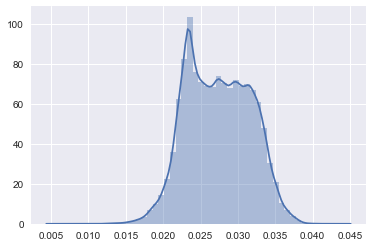

In [19]:
sns.distplot(w_reg.predict(Deals_MosPrime_Reg[cols]));
print ('Min spread: %.3f%%' % (100 * np.min(w_reg.predict(Deals_MosPrime_Reg[cols]))))
print ('Max spread: %.3f%%' % (100 * np.max(w_reg.predict(Deals_MosPrime_Reg[cols]))))
print ()
print ('MAE: %d bps' % int(10000 * mean_absolute_error(y_true=Deals_MosPrime_Reg[target],
                                                       y_pred=w_reg.predict(Deals_MosPrime_Reg[cols]))))

In [20]:
All_res = pd.DataFrame(list(zip(cols, w_reg.coef_)))
All_res.columns = ['index', 0]
All_res = All_res.set_index('index')

Const_FE = All_res[All_res.index.str[:2] == 'C_'].reset_index()
Const_FE['index'] = Const_FE['index'].apply(lambda x: int(x[2:]))
Const_FE = Const_FE.set_index('index')

Tenor_FE = All_res[All_res.index.str[:2] == 'T_'].reset_index()
Tenor_FE['index'] = Tenor_FE['index'].apply(lambda x: int(x[2:]))
Tenor_FE = Tenor_FE.set_index('index')

Amount_log_FE = All_res[All_res.index.str[:4] == 'AMT_'].reset_index()
Amount_log_FE['index'] = Amount_log_FE['index'].apply(lambda x: int(x[4:]))
Amount_log_FE = Amount_log_FE.set_index('index')

MosPrime_FE = All_res[All_res.index.str[:3] == 'MS_'].reset_index()
MosPrime_FE['index'] = MosPrime_FE['index'].apply(lambda x: int(x[3:]))
MosPrime_FE = MosPrime_FE.set_index('index')

"""
Week_FE = All_res[All_res.index.str[:5] == 'Week_'].reset_index()
Week_FE['index'] = Week_FE['index'].apply(lambda x: int(x[5:]))
Week_FE = Week_FE.set_index('index')

Weekday_FE = All_res[All_res.index.str[:8] == 'Weekday_'].reset_index()
Weekday_FE['index'] = Weekday_FE['index'].apply(lambda x: int(x[8:]))
Weekday_FE = Weekday_FE.set_index('index')
"""

"\nWeek_FE = All_res[All_res.index.str[:5] == 'Week_'].reset_index()\nWeek_FE['index'] = Week_FE['index'].apply(lambda x: int(x[5:]))\nWeek_FE = Week_FE.set_index('index')\n\nWeekday_FE = All_res[All_res.index.str[:8] == 'Weekday_'].reset_index()\nWeekday_FE['index'] = Weekday_FE['index'].apply(lambda x: int(x[8:]))\nWeekday_FE = Weekday_FE.set_index('index')\n"

In [21]:
CRM_ID_list = list(set(Deals_MosPrime['CRM_ID']))
Product_list = list(set(Deals_MosPrime['Product']))

Output_Table = pd.DataFrame(list(product(CRM_ID_list, Product_list)))
Output_Table.columns = ['CRM_ID', 'Product']
Output_Table = Output_Table.set_index(['CRM_ID', 'Product'])

for CRM_ID in CRM_ID_list:
    GroupID = Comps.set_index('CRM-ID').loc[CRM_ID, 'GroupID']

    if (GroupID in suff_cols):
        for prod in Product_list:
            
            Output_Table.loc[(CRM_ID, prod), 'CCY'] = Currency

            Output_Table.loc[(CRM_ID, prod), 'Const'] = All_res.loc['Const', 0]
            if GroupID in Const_FE.index:
                Output_Table.loc[(CRM_ID, prod), 'Const'] += Const_FE.loc[GroupID, 0]

            Output_Table.loc[(CRM_ID, prod), 'Term'] = All_res.loc['Term', 0]
            if GroupID in Tenor_FE.index:
                Output_Table.loc[(CRM_ID, prod), 'Term'] += Tenor_FE.loc[GroupID, 0]
            if (Output_Table.loc[(CRM_ID, prod), 'Term'] > 0):
                mean_v = Deals_MosPrime[Deals_MosPrime['GroupID'] == GroupID]['Term'].mean()
                Output_Table.loc[(CRM_ID, prod), 'Const'] += Output_Table.loc[(CRM_ID, prod), 'Term'] * mean_v
                Output_Table.loc[(CRM_ID, prod), 'Term'] = 0
                
            Output_Table.loc[(CRM_ID, prod), 'Amount_log'] = All_res.loc['Amount_log', 0]
            if GroupID in Amount_log_FE.index:
                Output_Table.loc[(CRM_ID, prod), 'Amount_log'] += Amount_log_FE.loc[GroupID, 0]    
            if (Output_Table.loc[(CRM_ID, prod), 'Amount_log'] > 0):
                mean_v = Deals_MosPrime[Deals_MosPrime['GroupID'] == GroupID]['Amount_log'].mean()
                Output_Table.loc[(CRM_ID, prod), 'Const'] += Output_Table.loc[(CRM_ID, prod), 'Amount_log'] * mean_v
                Output_Table.loc[(CRM_ID, prod), 'Amount_log'] = 0
            
            Output_Table.loc[(CRM_ID, prod), 'Benchmark'] = All_res.loc['MosPrimeBase', 0]
            if GroupID in MosPrime_FE.index:
                Output_Table.loc[(CRM_ID, prod), 'Benchmark'] +=  MosPrime_FE.loc[GroupID, 0] 
            if (Output_Table.loc[(CRM_ID, prod), 'Benchmark'] < 0):
                mean_v = Deals_MosPrime[Deals_MosPrime['GroupID'] == GroupID]['MosPrimeBase'].mean()
                Output_Table.loc[(CRM_ID, prod), 'Const'] += Output_Table.loc[(CRM_ID, prod), 'Benchmark'] * mean_v
                Output_Table.loc[(CRM_ID, prod), 'Benchmark'] = 0
            
            if prod in Prod_cols:
                Output_Table.loc[(CRM_ID, prod), 'Const'] += All_res.loc[prod, 0]

            """
            Output_Table.loc[inn, 'DepositIsTopup'] = max(All_res.loc['DepositIsTopup', 0], 0.0)
            Output_Table.loc[inn, 'IsPartWithdraw'] = max(All_res.loc['IsPartWithdraw', 0], 0.0)
            Output_Table.loc[inn, 'IsFullWithdraw'] = max(All_res.loc['IsFullWithdraw', 0], 0.0)
            """

for prod in Product_list:

    Output_Table.loc[('Default', prod), 'CCY'] = Currency
    Output_Table.loc[('Default', prod), 'Const'] = All_res.loc['Const', 0]

    Output_Table.loc[('Default', prod), 'Term'] = All_res.loc['Term', 0]
    if (Output_Table.loc[('Default', prod), 'Term'] > 0):
        mean_v = Deals_MosPrime[~Deals_MosPrime['GroupID'].isin(suff_cols)]['Term'].mean()
        Output_Table.loc[('Default', prod), 'Const'] += Output_Table.loc[('Default', prod), 'Term'] * mean_v
        Output_Table.loc[('Default', prod), 'Term'] = 0

    Output_Table.loc[('Default', prod), 'Amount_log'] = All_res.loc['Amount_log', 0]
    if (Output_Table.loc[('Default', prod), 'Amount_log'] > 0):
        mean_v = Deals_MosPrime[~Deals_MosPrime['GroupID'].isin(suff_cols)]['Amount_log'].mean()
        Output_Table.loc[('Default', prod), 'Const'] += Output_Table.loc[('Default', prod), 'Amount_log'] * mean_v
        Output_Table.loc[('Default', prod), 'Amount_log'] = 0

    Output_Table.loc[('Default', prod), 'Benchmark'] = All_res.loc['MosPrimeBase', 0]
    if (Output_Table.loc[('Default', prod), 'Benchmark'] < 0):
        mean_v = Deals_MosPrime[~Deals_MosPrime['GroupID'].isin(suff_cols)]['MosPrimeBase'].mean()
        Output_Table.loc[('Default', prod), 'Const'] += Output_Table.loc[('Default', prod), 'Benchmark'] * mean_v
        Output_Table.loc[('Default', prod), 'Benchmark'] = 0

    if prod in Prod_cols:
        Output_Table.loc[('Default', prod), 'Const'] += All_res.loc[prod, 0]

"""
for iter_date in (datetime.today().date() + timedelta(d) for d in range(366)):
    seas_FE = 0.0
    
    if iter_date.isocalendar()[1] in Week_FE.index:
        seas_FE += Week_FE.loc[iter_date.isocalendar()[1], 0]
    if iter_date.weekday() in Weekday_FE.index:
        seas_FE += Weekday_FE.loc[iter_date.weekday(), 0]
    
    Output_Table["y%d,m%d,d%d" % (iter_date.year, iter_date.month, iter_date.day)] = seas_FE
"""

Output_Table = Output_Table.dropna().reset_index()

Output_Table

,CRM_ID,Product,CCY,Const,Term,Amount_log,Benchmark
0,1-5YZSCS,NSO,RUB,0.069014,0.000000,-0.003175,0.186956
1,1-5YZSCS,Deposit,RUB,0.069054,0.000000,-0.003175,0.186956
2,1-9O6Y36,NSO,RUB,0.081646,0.000000,-0.003941,0.214328
3,1-9O6Y36,Deposit,RUB,0.081686,0.000000,-0.003941,0.214328
4,1-303DIQ,NSO,RUB,0.048411,-0.000986,-0.001629,0.132228
5,1-303DIQ,Deposit,RUB,0.048451,-0.000986,-0.001629,0.132228
6,1-9ITHFV,NSO,RUB,0.068687,-0.000526,-0.002256,0.000000
7,1-9ITHFV,Deposit,RUB,0.068726,-0.000526,-0.002256,0.000000
8,1-HFW5Z,NSO,RUB,0.071337,-0.000011,-0.002802,0.094455
9,1-HFW5Z,Deposit,RUB,0.071377,-0.000011,-0.002802,0.094455


In [34]:
Output_Table_Test = Output_Table.set_index(['CRM_ID', 'Product', 'CCY'])

test_res = []
for row in Deals_MosPrime.sample(n = 25000).iterrows():
    if (row[1]['CRM_ID'] in Output_Table_Test.index.get_level_values(0)):
        index = (row[1]['CRM_ID'], row[1]['Product'], row[1]['CCY'])
    else:
        index = ('Default', row[1]['Product'], row[1]['CCY'])
        
    coef_row = Output_Table_Test.loc[index]
    
    res = (coef_row['Const'] + coef_row['Term'] * row[1]['Term'] + 
           coef_row['Amount_log'] * row[1]['Amount_log'] +
           coef_row['Benchmark'] * row[1]['MosPrimeBase'])
    
    test_res.append(res)

0.009435877487906395 0.04405311222344453


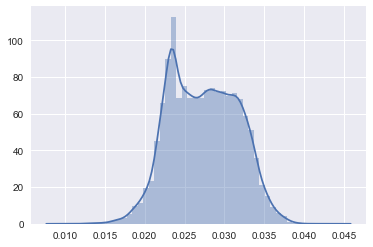

In [35]:
sns.distplot(test_res);
print (np.min(test_res), np.max(test_res))

In [36]:
writer = pd.ExcelWriter('RUB_deals_pricing.xlsx')
Output_Table.to_excel(writer, 'Sheet1')
writer.save()